In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask.array as da
import matplotlib.pyplot as plt
from MHW_daily_calcs import *

In [2]:
climyrs=[1993,2023]

In [3]:
flist=[fnameOISSTDailyGrid2(yrlims) for yrlims in ylimlistobs]

In [4]:
flist

['/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/OISST/oisst-avhrr-v02r01.regridded1x1g2.daily.1991_2000.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/OISST/oisst-avhrr-v02r01.regridded1x1g2.daily.2001_2010.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/OISST/oisst-avhrr-v02r01.regridded1x1g2.daily.2011_2020.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/OISST/oisst-avhrr-v02r01.regridded1x1g2.daily.2021_2024.nc']

In [5]:
fg2=xr.open_mfdataset(flist,decode_times=False,parallel=True)
fg2

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 12235, lat: 180, lon: 360)
Coordinates:
  * time     (time) float32 49kB 4.748e+03 4.749e+03 ... 1.698e+04 1.698e+04
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 3GB dask.array<chunksize=(3653, 180, 360), meta=np.ndarray>
    ice      (time, lat, lon) float32 3GB dask.array<chunksize=(3653, 180, 360), meta=np.ndarray>
    err      (time, lat, lon) float32 3GB dask.array<chunksize=(3653, 180, 360), meta=np.ndarray>

In [6]:
sst=fg2.sst.data.rechunk((len(fg2.time.values),90,90))
sst

dask.array<rechunk-merge, shape=(12235, 180, 360), dtype=float32, chunksize=(12235, 90, 90), chunktype=numpy.ndarray>

In [7]:
fg2.time

<xarray.DataArray 'time' (time: 12235)> Size: 49kB
array([ 4748.,  4749.,  4750., ..., 16980., 16981., 16982.], dtype=float32)
Coordinates:
  * time     (time) float32 49kB 4.748e+03 4.749e+03 ... 1.698e+04 1.698e+04
Attributes:
    long_name:     Center time of the day
    units:         days since 1978-01-01 12:00:00
    cell_methods:  time: mean

In [8]:
tdt=np.array([dt.datetime(1978,1,1,12)+dt.timedelta(days=float(el)) for el in fg2.time.values])
tdt[0],tdt[-1]

(datetime.datetime(1991, 1, 1, 12, 0), datetime.datetime(2024, 6, 30, 12, 0))

In [9]:
yd=np.array([(dt.datetime(el.year,el.month,el.day)-dt.datetime(el.year-1,12,31)).days for el in tdt])

In [10]:
%%time
climsst=np.zeros((365,180,360))
for iyd in range(1,3):#366):
    ind=yd==iyd
    if iyd==365: ind=np.logical_or(ind,yd==366)
    indyrs=np.array([(el.year>=climyrs[0])&(el.year<=climyrs[-1]) for el in tdt])
    ind=np.logical_and(ind,indyrs)
    climsst[iyd-1,:,:]=sst.mean(axis=0)
    if iyd%10==0: print(iyd)

CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 4.53 ms


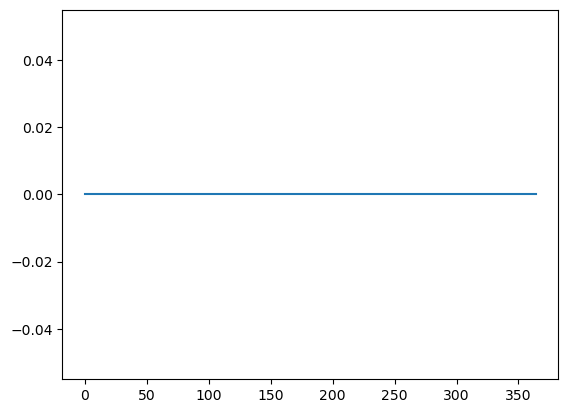

In [12]:
# ds=xr.Dataset(data_vars={'sst':(['yearday','lat','lon'],climsst)},
#                              coords={'yearday':yd,
#                                      'lat':fg2.lat,
#                                      'lon':fg2.lon}))
fout=fnameOISSTDailyClim(climyrs[0],climyrs[-1])
#ds.to_netcdf(fout,mode='w')
fclim=xr.open_dataset(fout,decode_times=False)
plt.plot(fclim.sst[:,120,200])

In [13]:
np.nanmax(fclim.sst)

np.float64(0.0)

In [14]:
fclim.close()